<a href="https://colab.research.google.com/github/MatheusRangelCardoso/tcc-bi-master-2019.1/blob/main/TCC_Energia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
# Importando Bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Carregar dados Energia:

In [88]:
drive.mount('/content/drive')
workdir_path = '/content/drive/My Drive/TCC' #Caminho para o workspace
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
df_energia = pd.read_csv("energy_dataset.csv",               #Carregar o Arquivo
                         parse_dates=["time"],               #Utilziar a coluna "time" como tipo "data/hora"
                         infer_datetime_format=True,)        #Inferir o o tipo de dados "data/hora" no dataframe
df_energia.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [90]:
# Linhas e Colunas
df_energia.shape

(35064, 29)

## Verificar o tipo dos dados:

In [91]:
# Tipo de dados
df_energia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

# Registros Duplicados:

In [92]:
sum(df_energia.duplicated())

0

## Estatísticas Básicas:

In [93]:
df_energia.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


**Conclusões:**
<br>
Colunas que só apresentam valor "0" ou nulo "NaN" deverão ser removidas. Visto que não poderão ser utilizadas para a construção do modelo pois elas não carregam em sí nenhuma informação.
<br>
<br>
Colunas:
<br>
1 - generation fossil coal-derived gas
<br>
2 - generation fossil oil shale
<br>
3 - generation fossil peat
<br>
4 - generation geothermal
<br>
5 - generation hydro pumped storage aggregated
<br>
6 - generation marine
<br>
7 - generation wind offshore
<br>
<br>
Colunas que contém a previsão de consumo um dia a frente não serão utilizadas para a construção do modelo. Pois é uma "previsão" e não sabemos como esses valores foram inferidos. É mais seguro utilizarmos dados históricos para a construção do modelo.
<br>
<br>
Colunas:
<br>
8 - forecast solar day ahead
<br>
9 - forecast wind offshore eday ahead
<br>
10 - forecast wind onshore day ahead
<br>
11 - total load forecast

In [94]:
df_energia = df_energia.drop(["generation fossil coal-derived gas",
                             "generation fossil oil shale",
                             "generation fossil peat",
                             "generation geothermal",
                             "generation hydro pumped storage aggregated",
                             "generation marine",
                             "generation wind offshore",
                             "forecast solar day ahead",
                             "forecast wind offshore eday ahead",
                             "forecast wind onshore day ahead",
                             "total load forecast"],
                             axis = 1)

df_energia.shape

(35064, 18)

## Registros Nulos
<br>
Lidando com regitros nulos em séries temporais:
<br>
<br>
Quando um registro nulo é encontrado em uma série temporal, não é recomendado substituir o valor pela média ou pela mediana. Pois isto poderia causar um viés nos dados visto que uma série temporal, os dados foram retirados em um intervalo de tempo pré determinado (no caso deste conjunto de dados, o intervalo ocorre de 1 em 1 hora). Desta forma substituir o valor pela média ou excluir completamente alinha é inviável. E excluir completamente a coluna também pois todas as variáveis apresentam um dado faltante.


In [95]:
df_energia.isnull().sum()

time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

**Conclusões:**
<br>
Há registros nulos nos dados. A base de dados contém 35064 registros e a coluna que contém maior registros nulos "total load actual" contém 36 registros nulos (cerca de 0,001% [36/35064] de registros). Desta maneira, será reaizada uma análisa para verificar o que fazer com os registros nulos.
<br>
<br>
A coluna "price actual" que é a "target variable" não apresenta nenhum registro nulo. O que é bom, pois evitaria a necessidade de excluir um registro do conjunto de dados (eliminando uma observação do intervalo de tempo do conjunto) ou evitaria a necessidade de uma criação de uma variável sintética para um determinado intervalo de tempo (o que poderia prejudicar a capacidade preditiva do modelo)


In [96]:
df_energia[df_energia["total load actual"].isnull()]

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
108,2015-01-05 12:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.50,79.14
109,2015-01-05 13:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.80,73.95
110,2015-01-05 14:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.50,71.93
111,2015-01-05 15:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.00,71.50
112,2015-01-05 16:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.00,71.85
113,2015-01-05 17:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.60,80.53
661,2015-01-28 13:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.00,77.62
751,2015-02-01 07:00:00+01:00,449.0,312.0,4765.0,5269.0,222.0,480.0,980.0,1174.0,7101.0,44.0,75.0,48.0,208.0,3289.0,NaN,56.10,16.98
752,2015-02-01 08:00:00+01:00,453.0,312.0,4938.0,5652.0,288.0,0.0,1031.0,3229.0,7099.0,44.0,75.0,73.0,207.0,3102.0,NaN,57.69,19.56
753,2015-02-01 09:00:00+01:00,452.0,302.0,4997.0,5770.0,296.0,0.0,1083.0,4574.0,7097.0,43.0,71.0,809.0,204.0,2838.0,NaN,60.01,23.13


# Verificar o comportamento dos registros nulos.

Será avaliado o comportameto dos rgistros nulos resente na coluna "total load actual", pois esta coluna contém o maior número de registros nulos.
<br>
<br>
Será realizada uma analise em três intervalos:
<br>
1) do registro 0 ao registro 120
<br>
2) do registro 80 ao registro 120
<br>
3) do registro 650 ao 780

In [97]:
# Do Registro 0 ao refistro 120
df_nulos_0 = df_energia [0:121]

# Do registro 80 ao registro 120
df_nulos_1 = df_energia[80:121]

# Do registro 650 ao registro 780
df_nulos_2 = df_energia[650:781]

# Realizar Interpolção

In [98]:
#Criando uma cópia do dataframe
df_energia_interpolacao=df_energia

In [99]:
# Realizando a interpolação na cópia acima
df_energia_interpolacao.interpolate(method='linear',
                                    limit_direction='forward',
                                    inplace=True,
                                    axis=0)

In [100]:
# Segmentando o dtatrarama nos mesmos intervalos para realizar a comparação
df_int_0 = df_energia_interpolacao [0:121]
df_int_1 = df_energia_interpolacao[80:121]
df_int_2 = df_energia_interpolacao[650:781]

# Comparando Interpolação de 0 a 120 registros

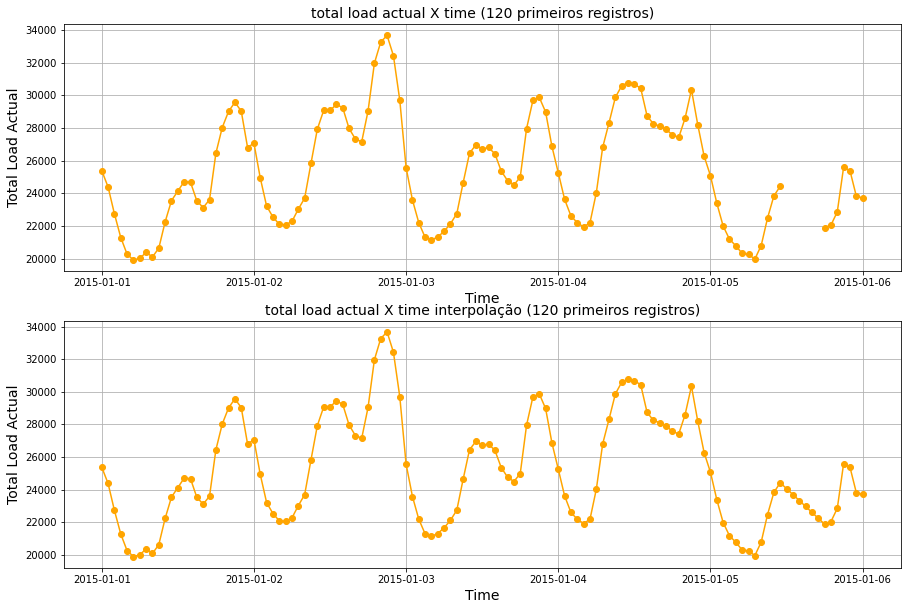

In [101]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_nulos_0['time'],df_nulos_0['total load actual'], color='orange', marker='o')
plt.title('total load actual X time (120 primeiros registros)', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Total Load Actual', fontsize=14)
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_int_0['time'],df_int_0['total load actual'], color='orange', marker='o')
plt.title('total load actual X time interpolação (120 primeiros registros)', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Total Load Actual', fontsize=14)
plt.grid(True)

plt.show()

# Comparando interpolação de 80 a 120 registros

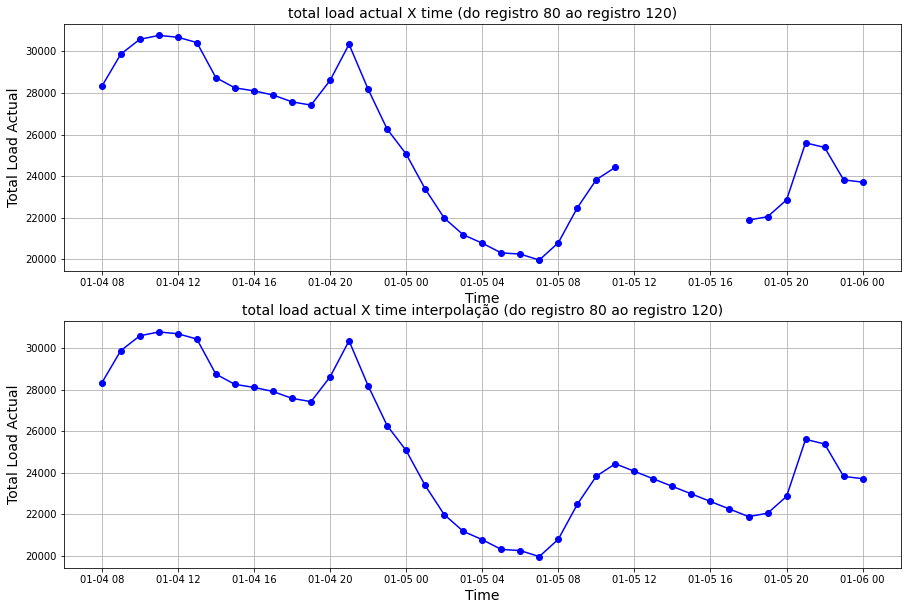

In [102]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_nulos_1['time'],df_nulos_1['total load actual'], color='blue', marker='o')
plt.title('total load actual X time (do registro 80 ao registro 120)', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Total Load Actual', fontsize=14)
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_int_1['time'],df_int_1['total load actual'], color='blue', marker='o')
plt.title('total load actual X time interpolação (do registro 80 ao registro 120)', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Total Load Actual', fontsize=14)
plt.grid(True)

plt.show()

# Comparando interpolação de 650 a 750 registro

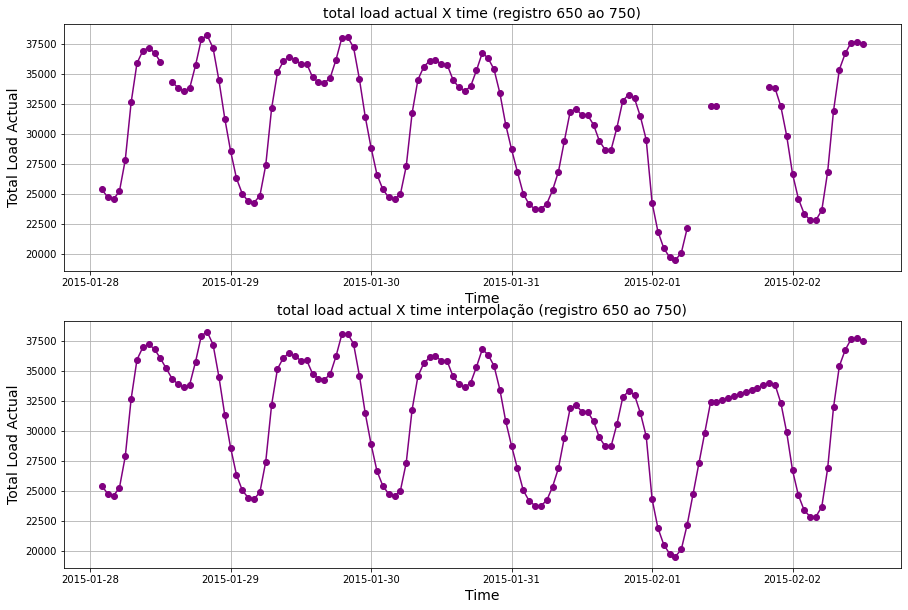

In [103]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_nulos_2['time'],df_nulos_2['total load actual'], color='purple', marker='o')
plt.title('total load actual X time (registro 650 ao 750)', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Total Load Actual', fontsize=14)
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_int_2['time'],df_int_2['total load actual'], color='purple', marker='o')
plt.title('total load actual X time interpolação (registro 650 ao 750)', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Total Load Actual', fontsize=14)
plt.grid(True)

plt.show()

In [104]:
#sobreescrevendo a base de dados de energia
df_energia=df_energia_interpolacao

# Carregar dados Clima

In [105]:
df_clima = pd.read_csv("weather_features.csv")
df_clima.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


**Informações Dataframe:**
<br>
Dataframe contendo informações sobre o cima em 5 cidades distintas da Espanha: Valencia, Madrid, Bilbao, Barcelona, Seville
<br>
<br>
**Colunas:**
<br>
<br>
**dt_iso** = Coluna de "Timestamp" contendo a data e a hora do período observado
<br>
<br>
**city_name** = Nome de cada ciadade (Valencia, Madrid, Bilbao, Barcelona, Seville)
<br>
<br>
**temp** = Temperatura (Kelvin)
<br>
<br>
**temp_min** = Temperatura mínima (Kelvin)
<br>
<br>
**temp_max** = Temperatura máxima (Kelvin)
<br>
<br>
**pressure** = Pressão (hectopascal - hPa)
<br>
<br>
**humidity** = Umidade
<br>
<br>
**wind_speed** = Velocidade do Vento (m/s)
<br>
<br>
**wind_deg** = "Wind Degrees" (direção do vento)
<br>
<br>
**rain_1h** = mm de chuva em 1 hora
<br>
<br>
**rain_3h** = mm de chuva em 3 horas
<br>
<br>
**snow_3h** = precipitação de neve em 3 horas
<br>
<br>
**clouds_all** = ??
<br>
<br>
**weather_id** = Código do clima
<br>
<br>
**weather_main** = descrição simples do clima
<br>
<br>
**weather_description** = descrição detalhada do clima
<br>
<br>
**weather_icon** = ícone do clima (possivelmnete extraido do sistema)
<br>
<br>
**Observações:**
<br>
<br>
1) A coluna **weather_icon** pode ser descartada.
<br>
<br>
2) As colunas **weather_id**, **weather_main** e **weather_description**, aparentemente possuem a mesma informação.
<br>
<br>
**Dúvida:**
<br>
se a coluana "rain_3h" mostra a quantidade de chuva em milimetros que caiu em um período de 3 horas... e coluna "rain_1h" mostra a mesma informação em um período de 1 hora... (as informaçeõs são redundantes não? [como se fosse o mesmo problema das colunas weather_id, weather_main e weather_description)) como eu verifico isso? Digo como eu verifico se a informação é redundante... (dá um merge com a "target variable" e verifica a correlação? Além disso mais a diante quando é realziado um ".describe()" desse datraframe, a média de rain_3h deveria ser maior do que rain_1h... mas isso não acontece (a media de rain 1h é maior do que rain 3h... oq eu não faz sentido...)... não sei se foi um problema no tratamento ou a informação está "ruim"? Eu nãi sei muito o qe fazer com rain 1h e rain 3h e nem sei se essa foi a melhor abordagem para as colunas weather_id, weather_main e weather_description.



## Descartando a coluna "weather_icon":

In [106]:
df_clima = df_clima.drop(['weather_icon'], axis=1)
df_clima.head(1)

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear


## Anásie das colunas weather_id, weather_main e weather_description:

### weather_id
Contém uma numeração com o id do clima.

In [107]:
df_clima['weather_id'].unique() #registros únicos na coluna weather_id

array([800, 801, 802, 803, 804, 500, 501, 502, 701, 522, 521, 503, 202,
       200, 201, 211, 520, 300, 741, 301, 711, 302, 721, 310, 600, 616,
       615, 601, 210, 602, 611, 311, 612, 620, 531, 731, 761, 771])

In [108]:
len(df_clima['weather_id'].unique()) # quantida de de registros únicos na coluna weather_id


38

### weather_main
Contém uma descrição simples do clima.

In [109]:
df_clima['weather_main'].unique() #registros únicos na coluna weather_main

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [110]:
len(df_clima['weather_main'].unique()) # quantida de de registros únicos na coluna weather_main

12

###weather_description
Contém uma descrição detalhada do clima.

In [111]:
df_clima['weather_description'].unique() #registros únicos na coluna weather_description

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'thunderstorm with rain',
       'proximity thunderstorm', 'thunderstorm',
       'light intensity shower rain', 'light intensity drizzle', 'fog',
       'drizzle', 'smoke', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light intensity drizzle rain',
       'light snow', 'rain and snow', 'light rain and snow', 'snow',
       'light thunderstorm', 'heavy snow', 'sleet', 'rain and drizzle',
       'shower sleet', 'light shower sleet', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain',
       'sand dust whirls', 'proximity drizzle', 'dust', 'squalls'],
      dtype=object)

In [112]:
len(df_clima['weather_description'].unique()) #registros únicos na coluna weather_description

43

**Conclusão**:
<br>
Retirar a coluna **"weather_main"** pois ela representa uma descrição menos "detalhada" em relação ao clima (apresenta 12 registros únicos)
<br>
<br>
Manter a coluna **weather_id** e realziar o one-hot-encoding da coluna **weather_description** pois esta coluna apresenta uma descrição mais tetalhada do clima (43 registros únicos) do que a coluna **"weather_main"**
<br>
<br>
Depois será comparada a **correlação** das colunas **weather_id** e **weather_description** com a variável resposta **"price actual"** (após a realziação do **"merge"** das bases de dados) para saber se estas colunas apresentam informações redundantes.


In [113]:
df_clima = df_clima.drop(['weather_main'], axis=1) # removendo a coluna #weather_main
df_clima.head(1)

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_description
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,sky is clear


In [114]:
# one_hot = pd.get_dummies(df_clima['weather_description']) # realizar one hot encoding para a coluna weather_description
# df_clima = df_clima.drop('weather_description',axis = 1) # remover a coluna weather_description do dataframe
# df_clima = df_clima.join(one_hot) # Realziar o join do "one_hot" com o dataframe
# df_clima.head(1)

In [115]:
# Linhas e Colunas
# df_clima.shape

Observação:
<br>
Não realziar o one hot enconding, pois ele acaba gerando 43 colunas (totalizando 57 colunas para esse dataframe e 293 colunas para o dataframe final (após realizar o merge dos dois dataframes) isso perde muito tempo treinando o modelo), além disso, após verificar a correlação destas colunas com a variável alvo, a correlação é nula... (não sei se deveria contecer isso pois é one hot encoding ou não). Segue imagem da correlação abaixo:
<br>
<br>
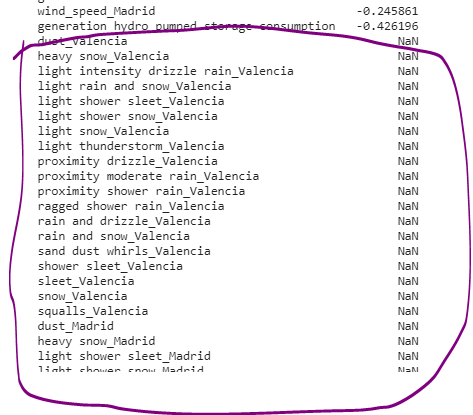

In [116]:
df_clima = df_clima.drop(['weather_description'], axis=1) # removendo a coluna weather_description
df_clima.shape

(178396, 14)

## Verificar o tipo dos dados:

In [117]:
# Tipo de dados
df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   dt_iso      178396 non-null  object 
 1   city_name   178396 non-null  object 
 2   temp        178396 non-null  float64
 3   temp_min    178396 non-null  float64
 4   temp_max    178396 non-null  float64
 5   pressure    178396 non-null  int64  
 6   humidity    178396 non-null  int64  
 7   wind_speed  178396 non-null  int64  
 8   wind_deg    178396 non-null  int64  
 9   rain_1h     178396 non-null  float64
 10  rain_3h     178396 non-null  float64
 11  snow_3h     178396 non-null  float64
 12  clouds_all  178396 non-null  int64  
 13  weather_id  178396 non-null  int64  
dtypes: float64(6), int64(6), object(2)
memory usage: 19.1+ MB


### Mudar o tipo dos dados:
será necessário mudar o tipo dos dados de int64 (número inteiro) para float64 (número decimal)

In [118]:
# Mudar o tipo das colunas do dataframe de int64 para float64
colunas = df_clima.select_dtypes(include=[np.int64]).columns #Seleciona as colunas que são do tipo int64

for coluna in colunas:
  df_clima[coluna] = df_clima[coluna].values.astype(np.float64) # Loop que converte a ista de colunas a cima de int64 para float 64

df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   dt_iso      178396 non-null  object 
 1   city_name   178396 non-null  object 
 2   temp        178396 non-null  float64
 3   temp_min    178396 non-null  float64
 4   temp_max    178396 non-null  float64
 5   pressure    178396 non-null  float64
 6   humidity    178396 non-null  float64
 7   wind_speed  178396 non-null  float64
 8   wind_deg    178396 non-null  float64
 9   rain_1h     178396 non-null  float64
 10  rain_3h     178396 non-null  float64
 11  snow_3h     178396 non-null  float64
 12  clouds_all  178396 non-null  float64
 13  weather_id  178396 non-null  float64
dtypes: float64(12), object(2)
memory usage: 19.1+ MB


## Verificar Duplicados:

In [119]:
sum(df_clima.duplicated())

21

In [120]:
df_valencia = df_clima[df_clima['city_name']=="Valencia"] # Seleciona só os registros com o valor de "Valencia" na coluna 'city_name'
df_valencia_duplicado = df_valencia[df_valencia.duplicated()] # Selecioan somente os valores duplicados do dataframe acima
df_valencia_duplicado

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
125,2015-01-06 04:00:00+01:00,Valencia,273.142,273.142,273.142,995.0,86.0,1.0,265.0,0.0,0.0,0.0,0.0,800.0
6566,2015-10-01 02:00:00+02:00,Valencia,289.740,286.480,292.040,1021.0,88.0,0.0,0.0,0.0,0.0,0.0,40.0,802.0
15345,2016-09-30 02:00:00+02:00,Valencia,288.060,285.370,291.250,1021.0,86.0,1.0,45.0,0.0,0.0,0.0,0.0,800.0
24135,2017-09-30 02:00:00+02:00,Valencia,292.150,292.150,292.150,1021.0,82.0,0.0,0.0,0.0,0.0,0.0,20.0,801.0
32900,2018-09-30 02:00:00+02:00,Valencia,292.150,292.150,292.150,1017.0,82.0,2.0,320.0,0.0,0.0,0.0,0.0,800.0


Aparentemente os valores duplicados são colunas que contém o mesmo valor. Como existem 5 cidades distintas e que as observações são realizadas de hora em hora, será necessário garantir que **não existe um registro duplicado, ou seja, um registro contendo um valor duplicado para uma mesma cidade em um mesmo horário.**
<br>
<br>
O método **".duplicated()"** está mostrando somente os registros duplicados em relação aos valores. Para verificar se existe um valor duplicado para uma mesma cidade em um mesmo horário, será necessário definir a coluna **"dt_iso"** como a coluna de índice do dataframe (garantir que não existe horários repetiods), depois agrupar os registros por cidade e depois comparar a quantidade desses registros com o "df_energia"
<br>
<br>
Primeiramente, para avaliar registros duplicados, vamos transformar a coluna "dt_iso", que contem o tempo de observação no índice do dataframe:

In [121]:
df_clima['time'] = pd.to_datetime(df_clima['dt_iso'], utc=True, infer_datetime_format=True) #Cria uma coluna "time" com a informação da coluna "dt_iso" no formato de timestamp
df_clima = df_clima.drop(['dt_iso'], axis=1) # apaga a coluna "dt_iso" do dataframe (ela não é mais necessária)
df_clima = df_clima.set_index('time') #tranforma a coluna "time" para o indice do dataframe
df_clima.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
time,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0


Será necessário agrupar, (utilziando o método **".groupby()"** o dataframe por cidade e ver se os registros batem com a quantidade de registros presentes na base de dados de energia (**"df_energia"**).
<br>
<br>
Ou seja, a quantidade de registros da base de dados de energia deverá ser a mesma quantidade  presente em cada cidade separadamente, caso a quantidade de registros presentes em cada cidade individualmente seja maior do que a quantidade de registros presentes no "df_energia", isto indica registros duplicados.

In [122]:
print('Registros "df_energia": {}\n'.format(df_energia.shape[0])) # printa  aquantidade de registros na base de dados "df_energia"

cidades = df_clima['city_name'].unique() # cria uma lista com o nome das 5 cidades tendo como base "df_clima"
clima_groupby = df_clima.groupby('city_name') # agrupa os registros do "df_clima" por cidade

for cidade in cidades:
    print('Cidade: {}\n'.format(cidade), #printa o  nome da cidade em que estamos realziando a coontafgem de registro,
          '  Registros: {}\n'.format(clima_groupby.get_group('{}'.format(cidade)).shape[0]), #Printa a quantidade de registrospresente na base "cila_groupby" [lembando que é uma base de dados agrupada por cidade então vai printar o número de registros por cidade]
          '  Há possíveis registros duplicados? {}\n'.format(not df_energia.shape[0]==clima_groupby.get_group('{}'.format(cidade)).shape[0]), # compara para ver se a quantidade  de registros presentes no "df_energia" é igual a quantidade  de registros presentes por cidade. Se for igual, ele rotorna "False", ou seja, não há registros duplicados, se for diferente ele reforna "True", ou seja, há possíbeus registros duplicados, ou seja, euma mesma cidade em um mesmo horário apresenta valores duplicados
          '  Análise Válida? {}\n'.format(df_energia.shape[0]<=clima_groupby.get_group('{}'.format(cidade)).shape[0])) # Ferifica se os registros das cidades são menores do que a quantidade de registros no "df_energia" se for menor, indica que há menos registros para essa cidade do que no número de observações em "df_energia", o que invalidaria completamente esta análise...


Registros "df_energia": 35064

Cidade: Valencia
   Registros: 35145
   Há possíveis registros duplicados? True
   Análise Válida? True

Cidade: Madrid
   Registros: 36267
   Há possíveis registros duplicados? True
   Análise Válida? True

Cidade: Bilbao
   Registros: 35951
   Há possíveis registros duplicados? True
   Análise Válida? True

Cidade:  Barcelona
   Registros: 35476
   Há possíveis registros duplicados? True
   Análise Válida? True

Cidade: Seville
   Registros: 35557
   Há possíveis registros duplicados? True
   Análise Válida? True



**Análise:**
<br>
Para todas as cidades, a quantidade de registros é maior do que a quantidade presente no "df_energia", o que indica que pode haver registros duplicados em todas as cidades.
<br>
<br>
Para eliminar as duplicadas, será necessário resetar o índice do dataframe, eliminar as duplicadas (deixando somente o promeiro registro para a chave composta "time" e "city_name") e colocar a coluna "time" como índice novamente.

In [123]:
df_clima = df_clima.reset_index().drop_duplicates(subset=['time','city_name'], keep='first').set_index('time') # Resetar o índice, remover duplicadas pela chave composta "time" e "city name", deixar o índice como "time"
df_clima.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
time,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0


## Validando duplicadas novamente:

In [124]:
print('Registros "df_energia": {}\n'.format(df_energia.shape[0])) # printa  aquantidade de registros na base de dados "df_energia"

cidades = df_clima['city_name'].unique() # cria uma lista com o nome das 5 cidades tendo como base "df_clima"
clima_groupby = df_clima.groupby('city_name') # agrupa os registros do "df_clima" por cidade

for cidade in cidades:
    print('Cidade: {}\n'.format(cidade), #printa o  nome da cidade em que estamos realziando a coontafgem de registro,
          '  Registros: {}\n'.format(clima_groupby.get_group('{}'.format(cidade)).shape[0]), #Printa a quantidade de registrospresente na base "cila_groupby" [lembando que é uma base de dados agrupada por cidade então vai printar o número de registros por cidade]
          '  Há possíveis registros duplicados? {}\n'.format(not df_energia.shape[0]==clima_groupby.get_group('{}'.format(cidade)).shape[0]), # compara para ver se a quantidade  de registros presentes no "df_energia" é igual a quantidade  de registros presentes por cidade. Se for igual, ele rotorna "False", ou seja, não há registros duplicados, se for diferente ele reforna "True", ou seja, há possíbeus registros duplicados, ou seja, euma mesma cidade em um mesmo horário apresenta valores duplicados
          '  Análise Válida? {}\n'.format(df_energia.shape[0]<=clima_groupby.get_group('{}'.format(cidade)).shape[0])) # Ferifica se os registros das cidades são menores do que a quantidade de registros no "df_energia" se for menor, indica que há menos registros para essa cidade do que no número de observações em "df_energia", o que invalidaria completamente esta análise...


Registros "df_energia": 35064

Cidade: Valencia
   Registros: 35064
   Há possíveis registros duplicados? False
   Análise Válida? True

Cidade: Madrid
   Registros: 35064
   Há possíveis registros duplicados? False
   Análise Válida? True

Cidade: Bilbao
   Registros: 35064
   Há possíveis registros duplicados? False
   Análise Válida? True

Cidade:  Barcelona
   Registros: 35064
   Há possíveis registros duplicados? False
   Análise Válida? True

Cidade: Seville
   Registros: 35064
   Há possíveis registros duplicados? False
   Análise Válida? True



**Análise:**
<br>
Aparentemente, o problema de registros duplicados foi solucionado.

## Estatísticas Básicas:

In [125]:
df_clima.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,175320.000000,175320.000000,175320.000000,1.753200e+05,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000
mean,289.707651,288.428433,291.172255,1.070199e+03,68.032307,2.470009,166.724909,0.069308,0.000386,0.004846,24.344057,763.452390
std,8.024910,7.948249,8.613916,6.021769e+03,21.838097,2.095140,116.548788,0.385915,0.007348,0.224547,30.339522,103.125539
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.830000,282.784586,284.909258,1.013000e+03,53.000000,1.000000,56.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.000000,178.000000,0.000000,0.000000,0.000000,16.000000,800.000000
75%,295.240000,294.150000,297.150000,1.022000e+03,87.000000,4.000000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.000000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


**Conclusões:**
<br>
A coluana "rain_3h" mostra a quantidade de chuva em milimetros que caiu em um período de 3 horas, a coluna "rain_1h" mostra a mesma informação em um período de 1 hora... (as informações são redundantes a quantidade de chuva, em milímetros, observada durante o período de 1 hora está contido dentro do período de 3 horas)
<br>
<br>
Além disto, a média de rain_3h deveria ser maior ou iagual do que rain_1h pois a quantidade de chuva observada durante o período de 1 hora está contido dentro do período de 3 horas.


# Registros Nulos:

In [126]:
df_clima.isnull().sum()

city_name     0
temp          0
temp_min      0
temp_max      0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
rain_1h       0
rain_3h       0
snow_3h       0
clouds_all    0
weather_id    0
dtype: int64

# Juntando os dataframes:

Ajustando o texto de **Barcelona**. Barcelona está com um espaço antes e será ajustado de **" Barcelona"** para **"Barcelona"**.

In [127]:
# Ajustando texto de "Barcelona"
df_clima['city_name'] = df_clima['city_name'].str.replace(" Barcelona","Barcelona")

### Ajustando a coluna Time
A coluna "time" não foi formatada para o tipo de data corretamente.
<br>
Será necessário realizar a conversão com o trecho de código abaixo:

In [128]:
# A coluna "time" não foi formatada para o tipo de data corretamente.
# Será necessário realizar a conversão com o trecho de código abaixo
df_energia['time'] = pd.to_datetime(df_energia['time'],
                                    utc=True,
                                    infer_datetime_format=True)

df_energia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35064 non-null  float64            
 2   generation fossil brown coal/lignite         35064 non-null  float64            
 3   generation fossil gas                        35064 non-null  float64            
 4   generation fossil hard coal                  35064 non-null  float64            
 5   generation fossil oil                        35064 non-null  float64            
 6   generation hydro pumped storage consumption  35064 non-null  float64            
 7   generation hydro run-of-river and poundage   35064 non-null  float64            
 8   generation hydro water res

Criando um dataframe para cada cidade

In [129]:
df_valencia = df_clima[df_clima['city_name']=="Valencia"]
df_madrid = df_clima[df_clima['city_name']=="Madrid"]
df_bilbao = df_clima[df_clima['city_name']=="Bilbao"]
df_barcelona = df_clima[df_clima['city_name']=="Barcelona"]
df_seville = df_clima[df_clima['city_name']=="Seville"]

In [130]:
# coloca um sufixo no nome de cada coluna de cada cidade
#sufixo =  armazena o nome da respectiva cidade presente nos dataframes nesta variável. Observação, o texto vem excrito ['Seville'] então a string foi manipulada para remover ops caracteres indesejáveis: ' ; [ ; ]

#sufixo = str(df_valencia['city_name'].unique()).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
#df_valencia = df_valencia.add_suffix('_{}'.format(sufixo))

#sufixo = str(df_madrid['city_name'].unique()).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
#df_madrid = df_madrid.add_suffix('_{}'.format(sufixo))

#sufixo = str(df_bilbao['city_name'].unique()).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
#df_bilbao = df_bilbao.add_suffix('_{}'.format(sufixo))

#sufixo = str(df_barcelona['city_name'].unique()).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
#df_barcelona = df_barcelona.add_suffix('_{}'.format(sufixo))

#sufixo = str(df_seville['city_name'].unique()).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
#df_seville = df_seville.add_suffix('_{}'.format(sufixo))

# faz uma cópia do df energia em uma variável chamada df_final'
#df_final = df_energia

# Colocando os dataframes em uma lista para a realização do "Merge":
#dfs_merge = [df_valencia, df_madrid, df_bilbao, df_barcelona, df_seville]


#realzia o merge dos dataframes de cada  cidade com o df energia
#for df in dfs_merge:
#  df_final = df_final.merge(df, on=['time'], how='outer')


# remove nome das colunas com city_name_nome da cidade:
#df_final = df_final.drop(['city_name_Valencia','city_name_Madrid','city_name_Bilbao','city_name_Barcelona','city_name_Seville'], axis=1)

#df_final


**Melhorando o processo acima em um loop (deixa menos código) o processo é o mesmo do que  foi descrito acima, avaliar se pode "apagar" o trecho acima ou deixa o decima como um comentário/comentar melhor**

In [131]:
#Melhorando o processo acima em um loop (deixa menos código) o processo é o mesmo do que  foi descrito acima,
#avaliar se pode "apagar" o trecho acima ou deixa o decima como um comentário/comentar melhor

# faz uma cópia do df energia em uma variável chamada df_final'
df_final = df_energia

# Colocando os dataframes em uma lista para a realização do "Merge":
dfs_merge = [df_valencia, df_madrid, df_bilbao, df_barcelona, df_seville]

for df in dfs_merge:
    # coloca um sufixo no nome de cada coluna de cada cidade (armazena o nome da respectiva cidade presente nos dataframes nesta variável. Observação, o texto vem excrito ['Seville'] então a string foi manipulada para remover ops caracteres indesejáveis: ' ; [ ; ])
    texto_cidade = str(df['city_name'].unique()).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    # Adiciona um "sufixo" em todas as colunas do dataframe com o texto da cidade acima. Por exemplo: coluna original: "city_name" coluna com o sufixo: "city_name_Seville", desta maneira será possível identificar os dados referentes a cada cidade após a realização do merge
    df = df.add_suffix('_{}'.format(texto_cidade))
    # realzia o merge dos dataframes de cada  cidade com o df energia
    df_final = df_final.merge(df, on=['time'], how='outer')
    # remove nome das colunas com city_name_nome da cidade:
    df_final = df_final.drop('city_name_{}'.format(texto_cidade), axis=1) # retira a coluna "city_name" com o respectivo sufixo do nome da cidade (não é uma coluna que agrega informação)
    


df_final

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia,weather_id_Valencia,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,rain_3h_Madrid,snow_3h_Madrid,clouds_all_Madrid,weather_id_Madrid,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,rain_3h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,weather_id_Bilbao,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,rain_3h_Barcelona,snow_3h_Barcelona,clouds_all_Barcelona,weather_id_Barcelona,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,rain_3h_Seville,snow_3h_Seville,clouds_all_Seville,weather_id_Seville
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.0,800.0,269.657312,269.657312,269.657312,1036.0,97.0,0.0,226.0,0.0,0.0,0.0,0.0,800.0,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,800.0,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,800.0
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.0,800.0,269.763500,269.763500,269.763500,1035.0,97.0,0.0,229.0,0.0,0.0,0.0,0.0,800.0,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,800.0,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,800.0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,800.0,269.251688,269.251688,269.251688,1036.0,97.0,1.0,224.0,0.0,0.0,0.0,0.0,800.0,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,800.0,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,800.0
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,800.0,269.203344,269.203344,269.203344,1035.0,97.0,1.0,225.0,0.0,0.0,0.0,0.0,800.0,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,800.0,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,800.0
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,800.0,269.485500,269.485500,269.485500,1035.0,97.0,1.0,221.0,0.0,0.0,0.0,0.0,800.0,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,800.0,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [132]:
df_final.shape

(35064, 78)

# Escolha de Variáveis

## rain_1h e rain_3h:
<br>
rain_1h = quantidade de chuva em millimetros durante 1h
<br>
<br>
rain_3h = quantidade de chuva em milímetros durante 3h
<br>
<br>
Blase clima -"rain_3h" e "rain_1h" as informaçeõs são "redundantes" a quantidade de chuva em milímetros durante 3 horas já está englobando a quantidade de chuva em milímetros duarante 1 hora. Pórem, como observado anteriormente, a média de chuva de rain_3h é menor do que rain_1h. Se rain_1h está contida dentro de rain_3h, era esperado da média de rain_3h ser maior ou igual a média de rain_1h.
<br>
<br>
Será apresentado gráficos com as colunas rain_1h e rain_3h para todas as cidades para uma análise dos dados destas variaáveis.

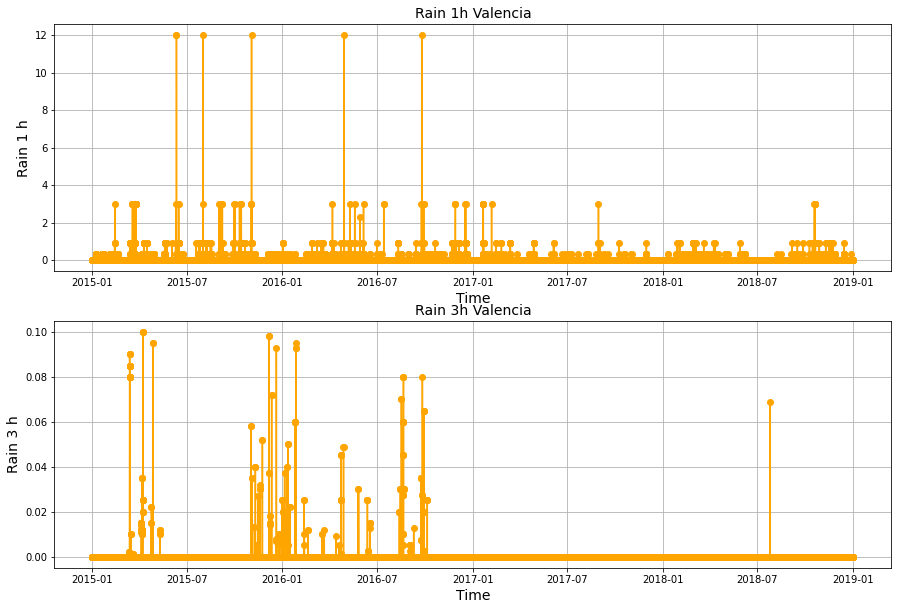

In [133]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_final['time'],df_final['rain_1h_Valencia'], color='orange', marker='o')
plt.title('Rain 1h Valencia', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 1 h', fontsize=14)
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_final['time'],df_final['rain_3h_Valencia'], color='orange', marker='o')
plt.title('Rain 3h Valencia', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 3 h', fontsize=14)
plt.grid(True)

plt.show()

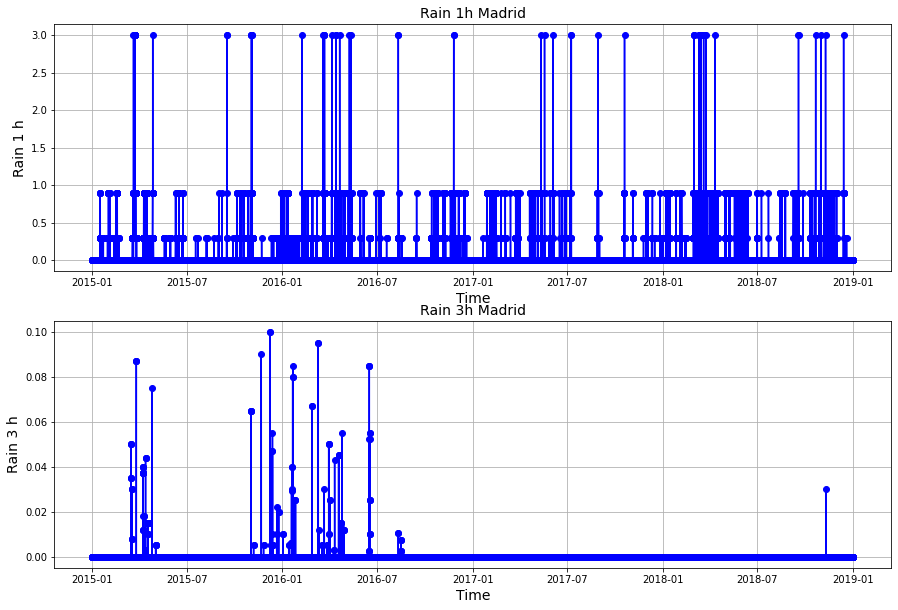

In [134]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_final['time'],df_final['rain_1h_Madrid'], color='blue', marker='o')
plt.title('Rain 1h Madrid', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 1 h', fontsize=14)
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_final['time'],df_final['rain_3h_Madrid'], color='blue', marker='o')
plt.title('Rain 3h Madrid', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 3 h', fontsize=14)
plt.grid(True)

plt.show()

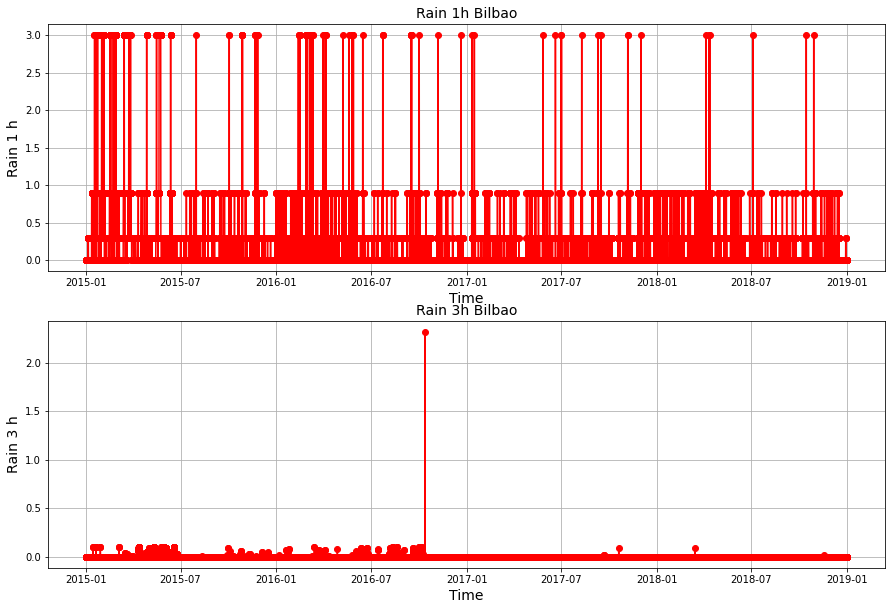

In [135]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_final['time'],df_final['rain_1h_Bilbao'], color='red', marker='o')
plt.title('Rain 1h Bilbao', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 1 h', fontsize=14)
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_final['time'],df_final['rain_3h_Bilbao'], color='red', marker='o')
plt.title('Rain 3h Bilbao', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 3 h', fontsize=14)
plt.grid(True)

plt.show()

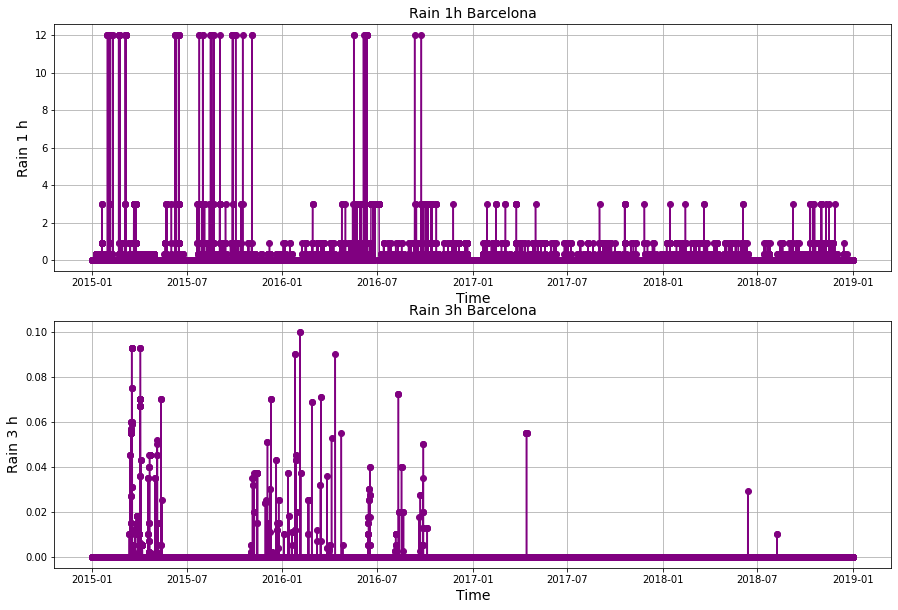

In [136]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_final['time'],df_final['rain_1h_Barcelona'], color='purple', marker='o')
plt.title('Rain 1h Barcelona', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 1 h', fontsize=14)
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_final['time'],df_final['rain_3h_Barcelona'], color='purple', marker='o')
plt.title('Rain 3h Barcelona', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 3 h', fontsize=14)
plt.grid(True)

plt.show()

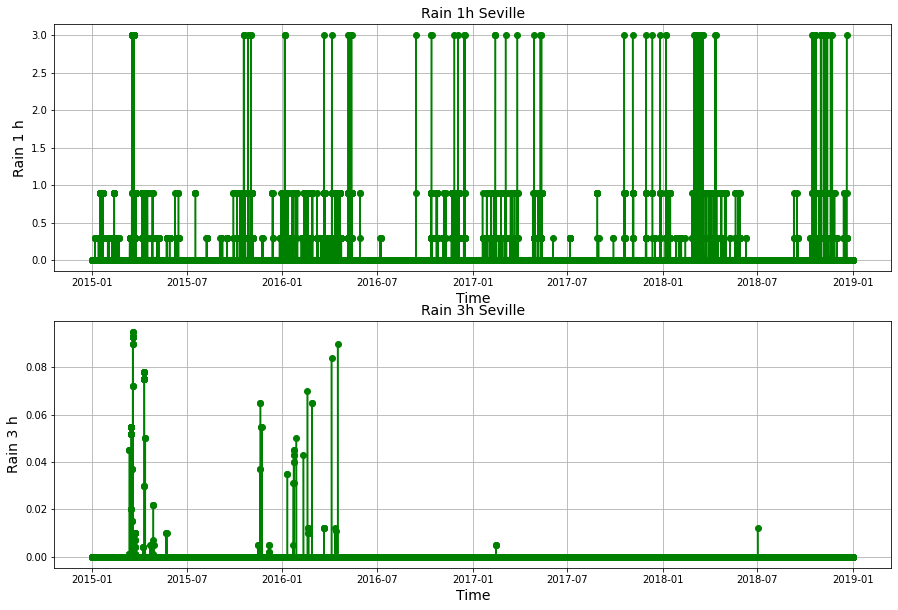

In [137]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_final['time'],df_final['rain_1h_Seville'], color='g', marker='o')
plt.title('Rain 1h Seville', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 1 h', fontsize=14)
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_final['time'],df_final['rain_3h_Seville'], color='g', marker='o')
plt.title('Rain 3h Seville', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 3 h', fontsize=14)
plt.grid(True)

plt.show()

Ao observar os pontos nos gráficos acima, constata-se que a variável "rain_3h", apresenta grande quantidade de registros igual a "0", enquanto para um mesmo intervalo de tempo, a variável "rain_1h" apresenta um valor diferente de 0.
<br>
<br>
Este é um dos motivos para a média de "rain_3h" estar maior do que "rain_1h". Como a coluna "rain_3h" apresenta uma grande quantidade de registros igual a "0", esta variável será eliminada da base de dados final.


In [138]:
df_final.shape

(35064, 78)

In [139]:
df_final = df_final.drop(['rain_3h_Valencia',
                          'rain_3h_Madrid',
                          'rain_3h_Bilbao',
                          'rain_3h_Barcelona',
                          'rain_3h_Seville'],
                         axis=1)
df_final.shape

(35064, 73)

#Correlação
<br>
Medido o coeficiente de correlação de Pearson.
<br>
<br>
Onde:
<br>
<br>
Correlação = 1:
<br>
Significa uma correlação perfeita e positiva entre a variável preditiva e a variável alvo. Ou seja, quando a variaável preditiva observada aumentar 1 unidade, a variável alvo almenta 1 unidade.
<br>
<br>
Correlação = -1:
Significa uma correlação perfeita e negativa entre a variável preditiva e a variável alvo. Ou seja, quando a variaável preditiva observada aumentar 1 unidade, a variável alvo diminuiu 1 unidade.
<br>
<br>
Correlação = 0:
Significa que não existe uma correlação linear entre as duas variáveis observadas.

In [140]:
correlacao = df_final.corr(method='pearson')
print(correlacao['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure_Bilbao                                0.194063
generation waste                               0.168710
generation biomass                             0.142671
temp_min_Valencia                              0.133141
temp_min_Barcelona                             0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Madrid                                0.096279
temp_Valencia                                  0.090505
pressure_Seville                               0

**Conclusões:**
<br>
As variáveis "snow_3h_Barcelona" e "snow_eh_Seville" não apresentam nenhum tipo de correlação linear com a variável alvo (price atual) e deverão ser removidas.

In [141]:
df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)
df_final.shape

(35064, 71)

# Criando o Modelo:

## Dividindo Variáveis:

In [142]:
df.shape

(35064, 13)

### Dividir a base de treino e teste
 - 70% treino (os 24545 primeiors registros)
 -30% teste (os 10519 últimos registros)

In [180]:
df_treino = df_final.iloc[:24545,]
df_teste = df_final.iloc[24545:,]

Retirar a variável alvo da base de treino e de teste, colocar o valor em uma variável chamada "df_vatiavel_alvo" para comparação

In [181]:
# Variaveis preditivas (retirar a coluna contendo avariável alvo do df_final)
df_variaveis_preditivas_treino = df_treino.drop(['price actual'], axis=1)
df_variaveis_preditivas_teste = df_teste.drop(['price actual'], axis=1)

# Variavel alvo (só pegar a coluna contendo a variavel alvo do df_final)
# Prgar só um array com os valores para realziar a normalziação
df_variavel_alvo_treino = df_final[['time','price actual']].iloc[:24545,]
df_variavel_alvo_teste = df_final[['time','price actual']].iloc[24545:,]

In [182]:
print(' df_final shape: {}\n'.format(df_final.shape),
      'df_variavies_preditivas_treino shape: {}\n'.format(df_variaveis_preditivas_treino.shape),
      'df_variavies_alvo_treimo shape: {}\n'.format(df_variavel_alvo_treino.shape),
      'df_variavies_preditivas_teste shape: {}\n'.format(df_variaveis_preditivas_teste.shape),
      'df_variavies_alvo_teste shape: {}\n'.format(df_variavel_alvo_teste.shape))

 df_final shape: (35064, 71)
 df_variavies_preditivas_treino shape: (24545, 70)
 df_variavies_alvo_treimo shape: (24545, 2)
 df_variavies_preditivas_teste shape: (10519, 70)
 df_variavies_alvo_teste shape: (10519, 2)



## Normalizando os dados:

### Treino

In [154]:
#####################################################################
# Antigo código de normalização, apagar quando o de baixo estiver ok#
#####################################################################

# Selecionar todas as colunas do dataframe "df_variaveis_preditivas" com excessão da coluna "time" (contém o timestamp e não pode ser normalizado)
#df_variaveis_preditivas_sem_time = df_variaveis_preditivas.loc[:, df_variaveis_preditivas.columns != 'time']

# Criar uma variável ("colunas_normalizar") contendo todos ons nomes das colunas do dataframe acima.
#colunas_normalizar = df_variaveis_preditivas_sem_time.columns.tolist()

# Criando o modelo escalar Min Max:
#escala_preditivas = MinMaxScaler(feature_range=(0, 1))

# treinar o modelo escalar acima apenas nas colunas que estão na lista "colunas_normalizar"). O método "fit_transform" retorna um objeto
# do tipo "numpy.array", ele será convertido em um objeto "pd.DataFrame" que será salvo em uma variável de nome "df_v_predivas_normalizado"
#df_variaveis_preditivas_normalizado = pd.DataFrame(escala_preditivas.fit_transform(df_variaveis_preditivas[colunas_normalizar].copy()), columns = colunas_normalizar)
#old_shape = df_variaveis_preditivas.shape

# exclui as colunas não normalizadas do "df_variaveis_preditivas"
#df_variaveis_preditivas.drop(colunas_normalizar, axis = 1, inplace = True)

# adiciona as colunas normalizadas presentes no "df_variaveis_preditivas_normalizado" ao "v_preditivas"
#df_variaveis_preditivas = pd.concat([df_variaveis_preditivas, df_variaveis_preditivas_normalizado], axis= 1)

# Realiza a valdiação, se der algo de errado é porque o processo de merge acima não funcionou
#assert old_shape == df_variaveis_preditivas.shape, "Erro Merge"

In [183]:
# Selecionar todas as colunas do dataframe "df_variaveis_preditivas_treino" com excessão da coluna "time" (contém o timestamp e não pode ser normalizado)
df_variaveis_preditivas_treino_sem_time = df_variaveis_preditivas_treino.loc[:, df_variaveis_preditivas_treino.columns != 'time']

# Criar uma variável ("colunas_normalizar") contendo todos ons nomes das colunas do dataframe acima.
colunas_normalizar = df_variaveis_preditivas_treino_sem_time.columns.tolist()

# Criando o modelo escalar Min Max:
escala_preditivas = MinMaxScaler(feature_range=(0, 1))

# treinar o modelo escalar acima apenas nas colunas que estão na lista "colunas_normalizar"). O método "fit_transform" retorna um objeto
# do tipo "numpy.array", ele será convertido em um objeto "pd.DataFrame" que será salvo em uma variável de nome "df_v_predivas_normalizado"
df_variaveis_preditivas_treino_normalizado = pd.DataFrame(escala_preditivas.fit_transform(df_variaveis_preditivas_treino[colunas_normalizar].copy()), columns = colunas_normalizar)
old_shape = df_variaveis_preditivas_treino.shape

# treinar o modelo min max com as variáveis de treino, para ser aplicado postriormente na base de teste:
escala_preditivas.fit(df_variaveis_preditivas_treino[colunas_normalizar])

# exclui as colunas não normalizadas do "df_variaveis_preditivas_treino"
df_variaveis_preditivas_treino.drop(colunas_normalizar, axis = 1, inplace = True)

# adiciona as colunas normalizadas presentes no "df_variaveis_preditivas_treino_normalizado" ao "v_preditivas"
df_variaveis_preditivas_treino = pd.concat([df_variaveis_preditivas_treino, df_variaveis_preditivas_treino_normalizado], axis= 1)

# Realiza a valdiação, se der algo de errado é porque o processo de merge acima não funcionou
assert old_shape == df_variaveis_preditivas_treino.shape, "Erro Merge"

### Teste

In [184]:
# treinar o modelo Min_Max na base de teste. Para isso, basta aplicar o modelo Mim_Max que foi treinado acima na base de treino
# nas cilunas da base de teste
df_variaveis_preditivas_teste[colunas_normalizar] = escala_preditivas.transform(df_variaveis_preditivas_teste[colunas_normalizar])

In [187]:
df_variaveis_preditivas_treino.tail()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia,weather_id_Valencia,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,snow_3h_Madrid,clouds_all_Madrid,weather_id_Madrid,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,weather_id_Bilbao,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,clouds_all_Barcelona,weather_id_Barcelona,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,clouds_all_Seville,weather_id_Seville
24540,2017-10-19 11:00:00+00:00,0.446029,0.630631,0.504321,0.590261,0.632597,0.014813,0.124396,0.051851,0.641598,0.553398,0.940594,0.457721,0.808917,0.263574,0.593889,0.589227,0.574663,0.574663,0.528804,0.330435,0.369565,0.015038,0.833333,0.0,0.0,0.20,0.995033,0.419082,0.396060,0.420608,0.756522,0.93,0.055556,0.000000,0.0,0.0,0.4,0.829187,0.470189,0.459386,0.445830,0.577465,0.640449,0.066667,0.000000,0.0,0.0,0.2,0.995033,0.581590,0.603822,0.506494,0.001003,1.00,0.066667,0.805556,0.075,0.90,0.531457,0.453431,0.478261,0.409212,0.216495,0.752688,0.066667,0.000000,0.0,0.20,0.995033
24541,2017-10-19 12:00:00+00:00,0.433809,0.571572,0.432653,0.564821,0.632597,0.088437,0.117150,0.052501,0.641011,0.543689,0.920792,0.439564,0.812102,0.332926,0.543527,0.577992,0.621922,0.621922,0.572292,0.330435,0.315217,0.007519,0.000000,0.0,0.0,0.20,0.995033,0.466645,0.437711,0.497020,0.756522,0.55,0.166667,0.722222,0.0,0.0,0.4,0.996683,0.528058,0.522030,0.486045,0.577465,0.505618,0.200000,0.388889,0.0,0.0,0.2,0.995033,0.603612,0.627127,0.525315,0.001002,0.88,0.066667,0.861111,0.025,0.75,0.529801,0.484531,0.500000,0.449956,0.226804,0.612903,0.000000,0.722222,0.0,0.75,0.998344
24542,2017-10-19 13:00:00+00:00,0.433809,0.566567,0.423094,0.535783,0.643646,0.168251,0.109300,0.032583,0.641598,0.543689,0.930693,0.405845,0.831210,0.394663,0.516410,0.543184,0.645552,0.645552,0.594036,0.321739,0.250000,0.015038,0.805556,0.0,0.0,0.40,0.996689,0.499776,0.479362,0.497020,0.747826,0.55,0.222222,0.666667,0.0,0.0,0.4,0.996683,0.549759,0.542911,0.506153,0.549296,0.505618,0.133333,0.000000,0.0,0.0,0.2,0.995033,0.614622,0.650431,0.525315,0.001001,0.88,0.000000,0.000000,0.025,0.75,0.496689,0.498457,0.521739,0.449956,0.226804,0.612903,0.133333,0.777778,0.0,0.20,0.995033
24543,2017-10-19 14:00:00+00:00,0.433809,0.525526,0.392957,0.506489,0.646409,0.209816,0.101449,0.034315,0.643067,0.543689,0.930693,0.371261,0.828025,0.455528,0.504527,0.518909,0.645552,0.645552,0.594036,0.321739,0.250000,0.007519,0.000000,0.0,0.0,0.40,0.996689,0.516037,0.500187,0.516123,0.747826,0.48,0.277778,0.666667,0.0,0.0,0.4,0.996683,0.549759,0.542911,0.506153,0.549296,0.550562,0.066667,0.305556,0.0,0.0,0.2,0.995033,0.603612,0.627127,0.525315,0.001000,0.93,0.066667,0.000000,0.075,0.90,0.531457,0.507740,0.521739,0.470328,0.216495,0.569892,0.266667,0.722222,0.0,0.20,0.995033
24544,2017-10-19 15:00:00+00:00,0.419552,0.531532,0.434327,0.523063,0.635359,0.179085,0.094203,0.040052,0.643361,0.543689,0.920792,0.307453,0.824841,0.490641,0.511274,0.558832,0.598292,0.598292,0.550548,0.313043,0.413043,0.045113,0.277778,0.0,0.0,0.75,0.998344,0.540428,0.521013,0.535226,0.747826,0.45,0.111111,0.805556,0.0,0.0,0.4,0.99668

In [186]:
df_variaveis_preditivas_teste.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia,weather_id_Valencia,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,snow_3h_Madrid,clouds_all_Madrid,weather_id_Madrid,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,weather_id_Bilbao,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,clouds_all_Barcelona,weather_id_Barcelona,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,clouds_all_Seville,weather_id_Seville
24545,2017-10-19 16:00:00+00:00,0.439919,0.527528,0.461115,0.538738,0.640884,0.098386,0.099638,0.071877,0.643655,0.553398,0.930693,0.171019,0.824841,0.478026,0.508880,0.597251,0.551033,0.551033,0.507060,0.321739,0.597826,0.022556,0.416667,0.025,0.0,0.75,0.496689,0.548559,0.521013,0.535226,0.747826,0.52,0.277778,0.694444,0.0,0.0,0.4,0.996683,0.559623,0.542911,0.526261,0.549296,0.471910,0.133333,0.472222,0.0,0.0,0.2,0.995033,0.592601,0.627127,0.506494,0.000999,1.00,0.333333,0.972222,0.250,0.90,0.533113,0.535823,0.565217,0.470328,0.216495,0.569892,0.266667,0.722222,0.0,0.2,0.995033
24546,2017-10-19 17:00:00+00:00,0.448065,0.560561,0.488280,0.549531,0.640884,0.034269,0.097826,0.146893,0.644242,0.553398,0.930693,0.042711,0.834395,0.445355,0.562201,0.604674,0.527403,0.527403,0.485316,0.330435,0.652174,0.015038,0.844444,0.000,0.0,0.40,0.996689,0.544900,0.541838,0.535226,0.756522,0.59,0.277778,0.694444,0.0,0.0,0.4,0.996683,0.525647,0.501148,0.506153,0.549296,0.505618,0.066667,0.388889,0.0,0.0,0.0,0.993377,0.603612,0.627127,0.525315,0.000999,0.93,0.266667,0.972222,0.075,0.75,0.531457,0.521665,0.543478,0.470328,0.216495,0.612903,0.200000,0.722222,0.0,0.2,0.995033
24547,2017-10-19 18:00:00+00:00,0.437882,0.564565,0.534997,0.580110,0.632597,0.000000,0.094203,0.158476,0.643067,0.553398,0.920792,0.008646,0.837580,0.437565,0.639288,0.660247,0.527403,0.527403,0.485316,0.339130,0.750000,0.007519,0.000000,0.000,0.0,0.40,0.996689,0.508110,0.479362,0.497020,0.756522,0.63,0.222222,0.638889,0.0,0.0,0.2,0.995025,0.471942,0.459386,0.445830,0.563380,0.685393,0.133333,0.277778,0.0,0.0,0.0,0.993377,0.614622,0.650431,0.525315,0.001000,0.93,0.266667,0.055556,0.075,0.76,0.531457,0.507740,0.521739,0.470328,0.226804,0.569892,0.266667,0.777778,0.0,0.2,0.995033
24548,2017-10-19 19:00:00+00:00,0.443992,0.592593,0.484068,0.562637,0.640884,0.000000,0.092995,0.158476,0.643361,0.543689,0.930693,0.006052,0.847134,0.442565,0.593671,0.605377,0.503773,0.503773,0.463571,0.339130,0.804348,0.007519,0.000000,0.000,0.0,0.40,0.996689,0.471523,0.437711,0.477917,0.765217,0.71,0.111111,0.694444,0.0,0.0,0.0,0.993367,0.428102,0.417624,0.405614,0.563380,0.797753,0.066667,0.000000,0.0,0.0,0.0,0.993377,0.625633,0.650431,0.544137,0.001001,0.93,0.266667,0.111111,0.000,0.76,0.998344,0.507740,0.521739,0.470328,0.237113,0.569892,0.200000,0.777778,0.0,0.0,0.993377
24549,2017-10-19 20:00:00+00:00,0.441955,0.611612,0.341218,0.527046,0.638122,0.006191,0.091184,0.064083,0.642773,0.504854,0.930693,0.005533,0.853503,0.434775,0.458692,0.558732,0.480143,0.480143,0.441827,0.347826,0.804348,0.007519,0.000000,0.000,0.0,0.20,0.995033,0.487378,0.479362,0.477917,0.773913,0.67,0.166667,0.722222,0.0,0.0,0.0,0

## Realizar o PCA

Sem usar o Timestamp???

In [ ]:
pca = PCA()
colunas_pca = colunas_normalizar #pegar todas as coluans do df_final menos a coluna "time"
pca_variaveis_preditivas = pca.fit_transform(df_variaveis_preditivas[colunas_pca])

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Cumulativa Explicada');

In [ ]:
colunas = [] #cria uma lista vazia para colocar o nome das colunas

contador = 0 # Cria um contador iniciaalizado em 0
for i in range((len(pca_variaveis_preditivas[0]))): # de um intevalo entra (0 ~ máximo de componentes no pca )
  texto = "PC {}".format(contador) # (adiciona em forma de exto "PC: "+ valor do contador)
  colunas.append(texto) # Adiciona o valor acima em uma lista de colunas
  contador = contador+1 # Adiciona mais uma unidade ao contador

# Cira um datafreame co todos os componentes principais para análise
df_pca = pd.DataFrame(data = pca_variaveis_preditivas, columns=colunas)
df_pca.head()

In [ ]:
colunas = [] #cria uma lista vazia para colocar o nome das colunas

contador = 0 # Cria um contador iniciaalizado em 0
for i in range((len(pca_variaveis_preditivas[0]))): # de um intevalo entra (0 ~ máximo de componentes no pca )
  texto = "PC {}".format(contador) # (adiciona em forma de exto "PC: "+ valor do contador)
  colunas.append(texto) # Adiciona o valor acima em uma lista de colunas
  contador = contador+1 # Adiciona mais uma unidade ao contador

# Cira um datafreame co todos os componentes principais para análise
df_pca = pd.DataFrame(data = pca_variaveis_preditivas, columns=colunas)
df_pca.head()

Usando o Timestamp???

In [ ]:
# Selecionar todas as colunas do dataframe "df_variaveis_preditivas" com excessão da coluna "time" (contém o timestamp e não pode ser normalizado)
df_variaveis_preditivas_sem_time = df_variaveis_preditivas.loc[:, df_variaveis_preditivas.columns != 'time']

# Criar uma variável ("colunas_pca") contendo todos ons nomes das colunas do dataframe acima.
colunas_pca = df_variaveis_preditivas_sem_time.columns.tolist()

# Criando o modelo PCA:
pca = PCA(0.95)

# treinar o modelo escalar acima apenas nas colunas que estão na lista "colunas_pca"). O método "fit_transform" retorna um objeto
# do tipo "numpy.array", ele será convertido em um objeto "pd.DataFrame" que será salvo em uma variável de nome "df_v_predivas_normalizado"
pca_variaveis_preditivas = pd.DataFrame(pca.fit_transform(df_variaveis_preditivas[colunas_pca].copy()), columns = colunas_pca)
old_shape = df_variaveis_preditivas.shape

# exclui as colunas não normalizadas do "df_variaveis_preditivas"
df_variaveis_preditivas.drop(colunas_pca, axis = 1, inplace = True)

# adiciona as colunas normalizadas presentes no "pca_variaveis_preditivas" ao "v_preditivas"
df_variaveis_preditivas = pd.concat([df_variaveis_preditivas, pca_variaveis_preditivas], axis= 1)

# Realiza a valdiação, se der algo de errado é porque o processo de merge acima não funcionou
assert old_shape == df_variaveis_preditivas.shape, "Erro Merge"

# Plota o gráfico do PCA:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Cumulativa Explicada');

In [ ]:
df_variaveis_preditivas.head()

Guia para o PCA (Como implementar o código):
<br>
https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
<br>
<br>
https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [ ]:
len(pca_df.columns)

## Divisão de Treino e Teste

## Criando LSTM

# Dúvidas:
<br>
1) Base de energia - Interpolação, o terceiro gráfico não ficou tão "bom", era para fazer ma forma de um "M", mas ele praticamente fez uma reta... Existe outra forma de interpolar?
<br>
<br>
2) Base de clima - weather_id, weather_main e weather_description, como escolher a melhor fariável. Eu devo fazer one-hot-encoding? Ou não? Posso ficar só com o weather ID?
<br>
<br>
3) Blase clima -"rain_3h" e "rain_1h" as informaçeõs são redundantes como verificar qual coluna devo usar? Quando é realziado um ".describe()" desse datraframe, a média de rain_3h deveria ser maior do que rain_1h... mas isso não acontece (a media de rain 1h é maior do que rain 3h... oque não faz sentido...)... não sei se foi um problema no tratamento ou a informação está "ruim"?
<br>
<br>
4) Agora que eu tenho os dataframes juntos (com o merge), como eu verifico quais informações utilizar? quais teste devo fazer? Verificar correlação? Existe algum outro teste estatístico?


#Anotações/teste de Códigos:
<br>
ignorar

In [ ]:
sum(df_clima.duplicated())

sum(df_clima.duplicated())

In [ ]:
clima_groupby.head()

In [ ]:
df_valencia = df_clima[df_clima['city_name']=="Valencia"] # Seleciona só os registros com o valor de "Valencia" na coluna 'city_name'
df_valencia_duplicado = df_valencia[df_valencia.duplicated()] # Selecioan somente os valores duplicados do dataframe acima
df_valencia_duplicado

df_valencia_duplicado[df_valencia_duplicado['temp']==270.475000]

In [ ]:
#a